# Deep $Q$-learning

### Recap tabulair $Q$-learning:
- **Kwaliteitsfunctie** geparameteriseerd door $Q(s, a)$
- Hoe goed is het om in state $s$ actie $a$ uit te voeren? 
- M.a.w. wat is de **maximale verwachte toekomstige reward** van een actie, gegeven een state?
$$
  \approx \max E[r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \dots]
$$
- Wanneer aantal states en actions klein is, kunnen we een tabel gebruiken als $Q$ functie
- Gegeven een $(s, a, s')$-triplet, waarbij:
  - $s$ is de huidige state
  - $a$ is de actie die we uitvoeren in $s$
  - $s'$ is de nieuwe state waar we in belanden na uitvoeren $a$ in $s$
- De update rule bij $Q$-learning is dan:
\begin{align*}
    Q(s, a) &\leftarrow Q(s, a) + \alpha [\gamma \max_{a'} Q(s', a') + R(s, a, s') - Q(s, a)]\\
    Q(s, a) &\leftarrow \underbrace{(1-\alpha)Q(s, a)}_{\text{aandeel oud}} + \underbrace{\alpha (R(s, a, s') + \gamma \max_{a'} Q(s', a'))}_{\text{aandeel nieuw}}
\end{align*}
- Met de **discount factor** $\gamma$ en de **learning rate** $\alpha$ als hyperparameters
- $R(s, a, s')$ is de reward functie waarvan de waardes aangeleverd worden vanuit de **omgeving**

In [1]:
dataset = [
    # episode 1
    ['B', 'east', 'C', -1],
    ['C', 'east', 'D', -1],
    ['D', 'exit', 'x', 10],
    # episode 2
    ['B', 'east', 'C', -1],
    ['C', 'east', 'D', -1],
    ['D', 'exit', 'x', 10],
    # episode 3
    ['E', 'north','C', -1],
    ['C', 'east', 'D', -1],
    ['D', 'exit', 'x', 10],
    # episode 4
    ['E', 'north','C', -1],
    ['C', 'east', 'A', -1],
    ['A', 'exit', 'x', 10],
]

states = ['A', 'B', 'C', 'D', 'E', 'x']
actions = ['east', 'west', 'south', 'north', 'exit']

Q = {s : {a : 0 for a in actions} for s in states}
alpha = 0.5
gamma = 1

for s, a, sn, r in dataset:
    max_Q_sn = max(Q[sn].values())
    Q[s][a] = (1-alpha) * Q[s][a] + alpha * (r + gamma * max_Q_sn)

Q

{'A': {'east': 0, 'west': 0, 'south': 0, 'north': 0, 'exit': 5.0},
 'B': {'east': -0.75, 'west': 0, 'south': 0, 'north': 0, 'exit': 0},
 'C': {'east': 1.5625, 'west': 0, 'south': 0, 'north': 0, 'exit': 0},
 'D': {'east': 0, 'west': 0, 'south': 0, 'north': 0, 'exit': 8.75},
 'E': {'east': 0, 'west': 0, 'south': 0, 'north': 1.75, 'exit': 0},
 'x': {'east': 0, 'west': 0, 'south': 0, 'north': 0, 'exit': 0}}

In [2]:
# gegeven dat we in state 'C' zitten, neem actie met de maximale waarde  
max(Q['C'].items(), key=lambda x: x[1])

('east', 1.5625)

### Beperking tabular $Q$-learning

- Als de state-action space groeit, dan krijgen we memory issues
$$
Q(s, a) = \begin{bmatrix}
    (s_1, a_1) & (s_1, a_2) & \dots & (s_1, a_N) \\
    (s_2, a_1) & (s_2, a_2) & \dots & (s_2, a_N) \\
    \vdots & \vdots & \ddots & \vdots \\
    (s_M, a_1) & (s_M, a_2) & \dots & (s_M, a_N)
\end{bmatrix}
$$
- Zowel $M$ als $N$ kunnen heel groot worden.


Oplossing: Neuraal netwerk gebruiken
- NN met 1 hidden layer is een *Universal Function Approximator* 
- **Disclaimer**: in praktijk heb je te maken met overfitting en een stijgende generalisatie error
- Hierdoor zijn diepere netwerken betrouwbaarder vanwege hun hogere capaciteit. 


Wat zijn **inputs** en **outputs** van een Deep $Q$-Network?

$$
    \dots \rightarrow \boxed{DQN} \rightarrow \dots
$$

$$
    Q(s): \begin{bmatrix} \vert \\ s \\ \vert \end{bmatrix} \rightarrow \boxed{DQN} \rightarrow \begin{bmatrix} a_1 \\ a_2 \\ \vdots \\ a_N \end{bmatrix}
$$

## Voorbeeld implementatie replay learning/offline learning

Voor een voorbeeld omgeving gebruiken we OpenAI's Gym library. 
- Omgeving: https://www.gymlibrary.dev/environments/classic_control/cart_pole/
- `observation_space` is hetzelfde als state space

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# torch imports 
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

# OpenAI gym
import gym                                
# Choose game (any in the gym should work)
env = gym.make('CartPole-v1') # ('MountainCar-v0')
env = env.unwrapped

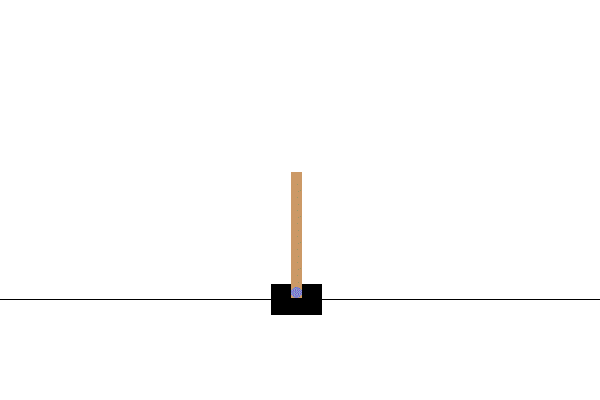

In [9]:
env.reset()

(array([ 0.03304203, -0.01727674,  0.01535294,  0.0279444 ], dtype=float32),
 {})

In [21]:
action = 0
obs_new, reward, done, _, info = env.step(action)
print(f"x-pos: {obs_new[0]:.4f}, velocity: {obs_new[1]:.4f}")
print(f"pole angle: {obs_new[2]:.4f}, pole velocity: {obs_new[3]:.4f}")
print(f"reward: {reward}")
print(f"info: {info}")
print(f"episode terminated? {'yes' if done else 'no'}")

x-pos: -0.2293, velocity: -2.3636
pole angle: 0.4320, pole velocity: 3.9494
reward: 0.0
info: {}
episode terminated? yes


### Custom torch module 

In [6]:
class LinearDQN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_out):
        super().__init__()
        self.linear1 = nn.Linear(n_inputs, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, n_out)
    
    def forward(self, X: torch.Tensor):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        return self.linear3(X)

### Loss + optimizer

In [22]:
D = []
train_loss_history = []
mean_loss_history = []

n_states = env.observation_space.shape[0]
n_actions = env.action_space.n

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LinearDQN(n_states*2, 200, n_actions).to(device)

criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

### Trainings constanten 

In [23]:
n_episodes = 4000    # hoeveel episodes
epsilon = 0.5        # epsilon-greedy search
gamma = 0.99         # discount factor
batch_size = 64      # hoeveel datapunten per optimalisatiestap

### Stap 1: observeren van omgeving

In [44]:
env.render_mode = None

for ep in range(n_episodes):

    state, _ = env.reset()
    state = np.append(state, state, axis=0)
    done = False

    while not done:
        # epsilon-greedy search
        if np.random.rand() < epsilon:
            action = env.action_space.sample() # random action
        else:
            # in eerste instantie niet getraind
            Q_pred = model(torch.tensor(state, device=device).float()) 
            action = torch.argmax(Q_pred).item()

        # doe actie en observeer
        state_new, reward, done, _, _ = env.step(action)

        # iedere observatie bestaat uit 2 achtereenvolgende states
        state_new = np.append(state[n_states:], state_new, axis=0)

        # sla observatie op
        D.append([*state, *state_new, action, reward, done])

        state = state_new # update state

### Stap 2: leren van observaties (experience replay)

In [45]:
from torch.utils.data.dataset import ConcatDataset, Dataset


class ObservationDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sample = (
            self.data[index, :2*n_states],            # state pair
            self.data[index, 2*n_states:4*n_states],  # new state pair
            self.data[index, 4*n_states:]             # action, reward, done
        )
        return sample

dataset = ObservationDataset(D)
len(dataset)
# dataset.__getitem__(2)

142130

$$
Loss = (Q_{old} - Q_{new})^2
$$

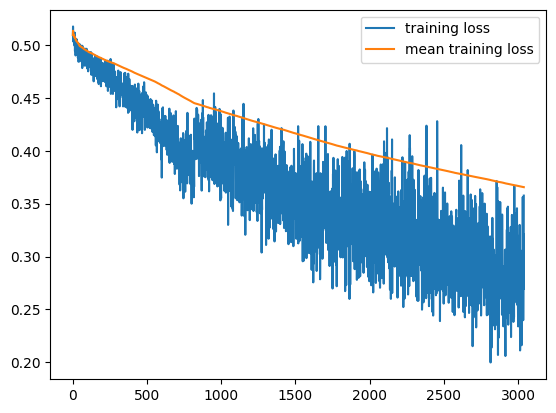

In [46]:
observations_dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for batch_states, batch_states_new, actions_rewards_done in observations_dl:
    # move batch to device
    batch_states, batch_states_new = batch_states.to(device), batch_states_new.to(device)

    actions = actions_rewards_done[:, 0].to(device)
    rewards = actions_rewards_done[:, 1].to(device)
    done    = actions_rewards_done[:, 2].to(device)

    # predict
    Q_preds = model(batch_states)
    
    # compute targets
    Q_targets = torch.clone(Q_preds)
    Q_new = model(batch_states_new)
    max_Q_sa_preds, _ = torch.max(Q_new, dim=1)
    idx_to_update = F.one_hot(actions.long(), num_classes=n_actions).bool()
    Q_targets[idx_to_update] = torch.where(done.bool() == True, rewards, rewards + gamma * max_Q_sa_preds)
    
    # loss
    loss = criterion(Q_targets, Q_preds)
    train_loss_history.append(loss.item())
    mean_loss_history.append(np.mean(train_loss_history))

    # optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(train_loss_history, label="training loss")
plt.plot(mean_loss_history, label="mean training loss")
plt.legend()

In [47]:
mean_loss_history[-1]

0.3655814526602626

### Stap 3: testen van model

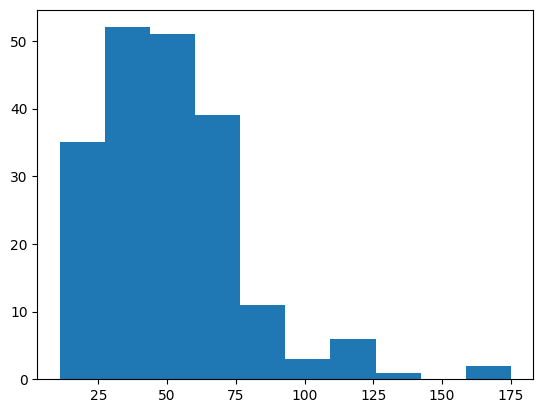

In [48]:
env.render_mode = None
n_test_episodes = 200
total_rewards = []

for _ in range(n_test_episodes):
    done = False
    total_reward = 0

    state, _ = env.reset()
    state = np.append(state, state, axis=0)

    while not done:
        
        Q = model(torch.tensor(state, device=device).float())
        action = torch.argmax(Q).item()
        state_new, reward, done, _, _ = env.step(action)

        state = np.append(state[n_states:], state_new, axis=0)

        total_reward += reward

    total_rewards.append(total_reward)

plt.hist(total_rewards)
plt.show()

In [49]:
np.mean(total_rewards)

50.8

In [54]:
done = False
total_reward = 0

state, _ = env.reset()
state = np.append(state, state, axis=0)

env.render_mode = 'human'

while not done:
    env.render()
    
    Q = model(torch.tensor(state, device=device).float())
    action = torch.argmax(Q).item()
    state_new, reward, done, _, _ = env.step(action)

    state = np.append(state[n_states:], state_new, axis=0)

    total_reward += reward

total_reward

58.0

: 

## Opdracht: Deep $Q$-learning Snake

Bekijk de code voor DQN snake. Er zijn 3 files `agent.py`, `game.py`, `model.py`
- Vind en beschrijf de **states** en **actions** in de DQN snake code.

Beschouw het volgende stuk code, waarin de oneindige cyclus van leven en leren wordt getoond:
```python
while True:
    # get old state
    state_old = agent.get_state(game)

    # get move
    final_move = agent.get_action(state_old)

    # perform move and get new state
    reward, done, score = game.play_step(final_move)
    state_new = agent.get_state(game)

    # train short memory
    agent.train_short_memory(state_old, final_move, reward, state_new, done)

    # remember
    agent.remember(state_old, final_move, reward, state_new, done)
``` 
- Beschrijf (via draw.io bijv.) een sequentie diagram voor één iteratie in de while-loop.